# Segmentation to coordinates

This notebook explains how we can go from image segmentation to object coordinates.

If you run out of CUDA memory, make sure you shutdown the python kernel of the other notebook.

In [1]:
!pip install albumentations==1.3.0
!git clone https://github.com/kevin-allen/unetTracker
!pip install -r unetTracker/requirements.txt
!pip install -e unetTracker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1
Cloning into 'unetTracker'...
remote: Enumerating objects: 941, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 941 (delta 194), reused 309 (delta 188), pack-reused 621
Receiving objects: 100% (941/941), 123.86 MiB | 17.32 MiB/s, done.
Resolving deltas: 100% (584/584), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.0/380.0 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 9.

Obtaining file:///content/unetTracker
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for unetTracker (pyproject.toml) ... done
  Created wheel for unetTracker: filename=unetTracker-0.0.1-0.editable-py3-none-any.whl size=16048 sha256=da1771c7cbb97a20a520f78cd72cd0fe8b0bc18f05dc7bcc85b3f17722adedf0
  Stored in directory: /tmp/pip-ephem-wheel-cache-7u8az_ac/wheels/62/9b/5a/0cb547490a9187d698861d98e1e803c5e64f31a9d899a8e84c
Successfully built unetTracker


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

fn = "/content/drive/My Drive/dsfolder"
if os.path.exists(fn):
  print("We can access the dsfolder directory.")
else:
  raise IOError("Problem accessing the dsfolder directory.")

We can access the dsfolder directory.


In [3]:
# this will run the code in the setup_project.py and create a variable called `project`
fn = "/content/drive/My Drive/dsfolder/setup_project.py"
if os.path.exists(fn):
  print("We can access the file.")
else:
  raise IOError("Problem accessing the file.")

%run "/content/drive/My Drive/dsfolder/setup_project.py"

We can access the file.
Project directory: /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker
Getting configuration from config file. Values from config file will be used.
Loading /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.5, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'finger_tracker', 'normalization_values': {'means': [0.40666553378105164, 0.45300230383872986, 0.5148566961288452], 'stds': [0.23905879259109497, 0.2506697177886963, 0.2679229974746704]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['f1', 'f2', 'f3', 'f4'], 'target_radius': 6, 'unet_features': [64, 128, 256, 512]}


In [4]:
import torch
import albumentations as A
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet

Get some predictions from the model.

In [5]:
VAL_IMAGE_DIR = os.path.join(project.dataset_dir,"val_images")
VAL_MASK_DIR =  os.path.join(project.dataset_dir,"val_masks")
VAL_COORDINATE_DIR = os.path.join(project.dataset_dir,"val_coordinates")
DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

In [6]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))
print(valTransform)

Loading valTransform from /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/augmentation/valTransform
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.40666553378105164, 0.45300230383872986, 0.5148566961288452], std=[0.23905879259109497, 0.2506697177886963, 0.2679229974746704], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [7]:
valDataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform,image_extension=project.image_extension)
dataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None,image_extension=project.image_extension)

In [8]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)
a = model.eval()

Let's get an item from the validation dataset

In [9]:
imageIndex=6
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

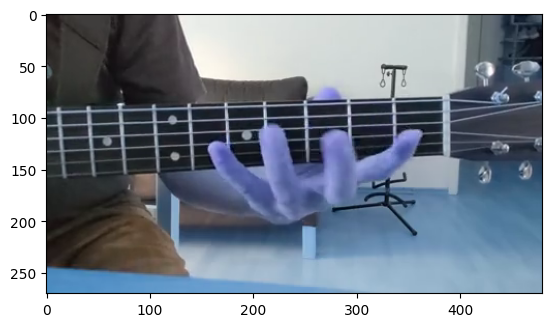

In [10]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [11]:
img = image.permute(1,2,0).numpy() #
msk = mask.numpy()

### Image and masks for an item of the validation set

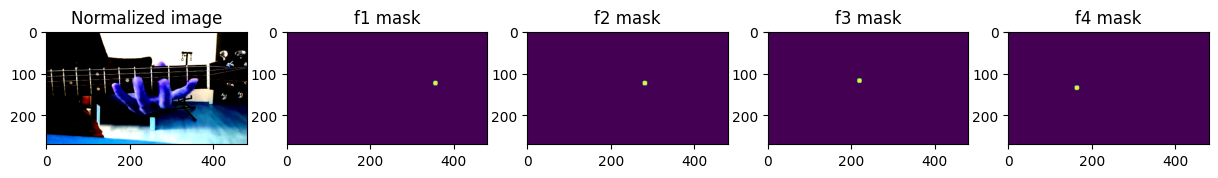

In [12]:
fig, ax = plt.subplots(1,msk.shape[0]+1,figsize=((msk.shape[0]+1)*3,3))
ax[0].imshow(img)
ax[0].set_title("Normalized image")
for i in range(msk.shape[0]):
    ax[i+1].imshow(msk[i])
    ax[i+1].set_title(project.object_list[i]+" mask")

### Image and mask predictions of an item of the validation set
Let's get the model output for this image.

If you use [torch.nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), you should apply a sigmoid function to the output as it is usually applied when calculating the loss.

The sigmoid function limits the range from 0 to 1.

In [13]:
%%time

image,mask,coord = valDataset[imageIndex]
image = image.unsqueeze(0).to(DEVICE)
output = torch.sigmoid(model(image))
output = output.detach().cpu().numpy()

CPU times: user 1.27 s, sys: 721 ms, total: 1.99 s
Wall time: 7.39 s


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


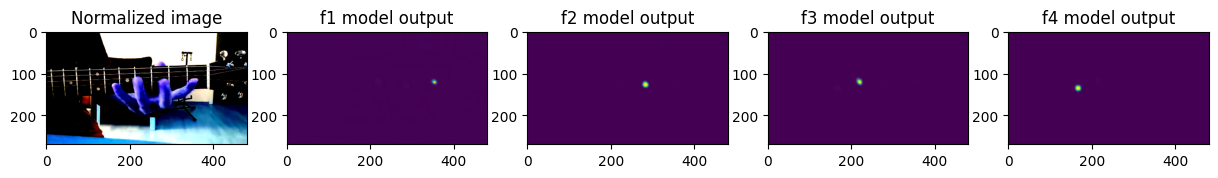

In [14]:
fig, ax = plt.subplots(1,output.shape[1]+1,figsize=((output.shape[1]+1)*3,3))
ax[0].imshow(img)
ax[0].set_title("Normalized image")
for i in range(output.shape[1]):
    ax[i+1].imshow(output[0,i])
    ax[i+1].set_title(project.object_list[i]+" model output")

## Extracting coordinate out of the mask

A detected object appears as a bright blob in a dark background.

We can use the cv2.SimpleBlobDetector to detect the objects.

In [15]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 30 # 100 # between 400 and 500 is the decision point
detector = cv2.SimpleBlobDetector_create(params)

In [16]:
blobs = imageOri.astype(np.uint8)
nObjects = output.shape[1]
pred = np.empty((output.shape[0],nObjects,3)) # x, y, probability
pred[:,:,:] = np.nan
pred[:,:,2] = output.reshape(nObjects,-1).max(axis=1) # maximal value in each object mask

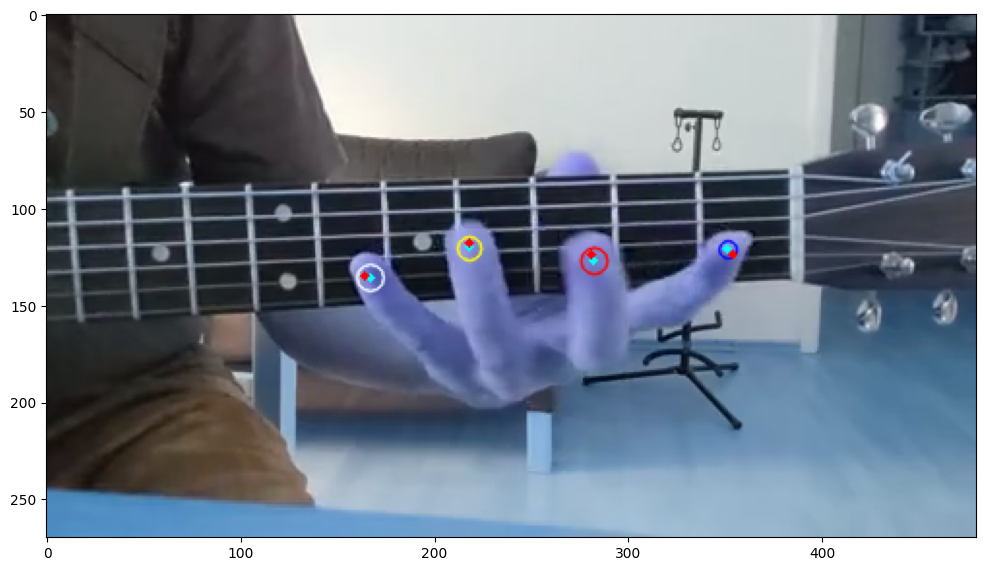

[[[351.61642456 121.4992981    0.53910905]
  [282.53677368 127.38360596   0.98111147]
  [218.16253662 120.95316315   0.90758228]
  [167.00753784 136.0020752    0.96363896]]]
[[354. 124.]
 [281. 124.]
 [218. 118.]
 [164. 135.]]


array([3.45469852, 3.71624308, 2.95763262, 3.17008495])

In [17]:
for item in range(1):
    for objectIndex in range(len(project.object_list)):

        out = output[item]
        outputT = np.expand_dims((out[objectIndex]*255).astype(np.uint8),2) # get output in unsigned int 8 format, values ranging from 0 to 255
        outputT= 255-outputT # reverse values because the SimpleBlobDetector is looking for dark blob


        keypoints = detector.detect(outputT)
        if keypoints:
            blank = np.zeros((1, 1))
            blobs = cv2.drawKeypoints(blobs, keypoints, blank, project.object_colors[objectIndex],cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            # find the largest blob
            largest_size=0
            pt = None
            for k in keypoints:
                if k.size>largest_size:
                    pt = k.pt
            pred[item,objectIndex,0] = pt[0]
            pred[item,objectIndex,1] = pt[1]
            cv2.circle(blobs,(int(pt[0]),int(pt[1])), 2, (0,255,255), -1)
            cv2.circle(blobs,(int(coord[objectIndex,0]),int(coord[objectIndex,1])), 2, (255,0,0), -1)
    plt.figure(figsize=(12,12))
    plt.imshow(blobs)
    plt.show()

print(pred)
print(coord)
# distance between predicted coordinates and labeled coordinates
np.sqrt(np.sum((coord-pred[0,:,0:2])**2,axis=1))

## CoordinatesFromSegmentationMask object
We have a class that will extract the predicted coordinates given an output.

In [18]:
image,mask,coord = valDataset[imageIndex]
image = image.unsqueeze(0).to(DEVICE)
output = torch.sigmoid(model(image))
output = output.detach().cpu().numpy()

In [20]:
from unetTracker.coordinatesFromSegmentationMask import CoordinatesFromSegmentationMask
cDetector = CoordinatesFromSegmentationMask()

In [21]:
pred = cDetector.detect(output)

In [22]:
pred , coord

(array([[[351.65945435, 121.53482056,   0.53910905],
         [282.55993652, 127.38923645,   0.98111147],
         [218.16253662, 120.95316315,   0.90758228],
         [167.0062561 , 136.03431702,   0.96363896]]]),
 array([[354., 124.],
        [281., 124.],
        [218., 118.],
        [164., 135.]]))

## Processing image from a video

If the images are coming from a video, we need to process them the same way we processed the images of the dataset. We do not to apply any translation, cropping, etc that is usually associated with data augmentation. In our project, the transformation applied to the validation set can work.

In [24]:
video_fn = '/content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/videos/human_hand.mp4'

Number of frames in /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/videos/human_hand.mp4: 5795
frame 187


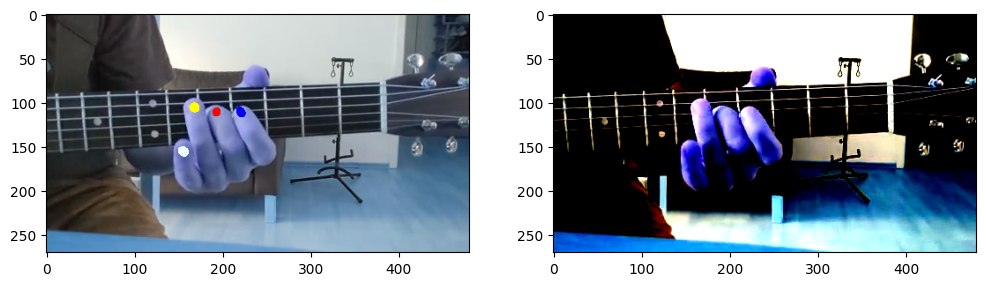

[[[220.71966553 110.81217957   0.88812971]
  [193.02493286 110.77108765   0.9396897 ]
  [168.04710388 105.4524231    0.93059742]
  [155.51997375 155.38766479   0.9462204 ]]]
frame 720


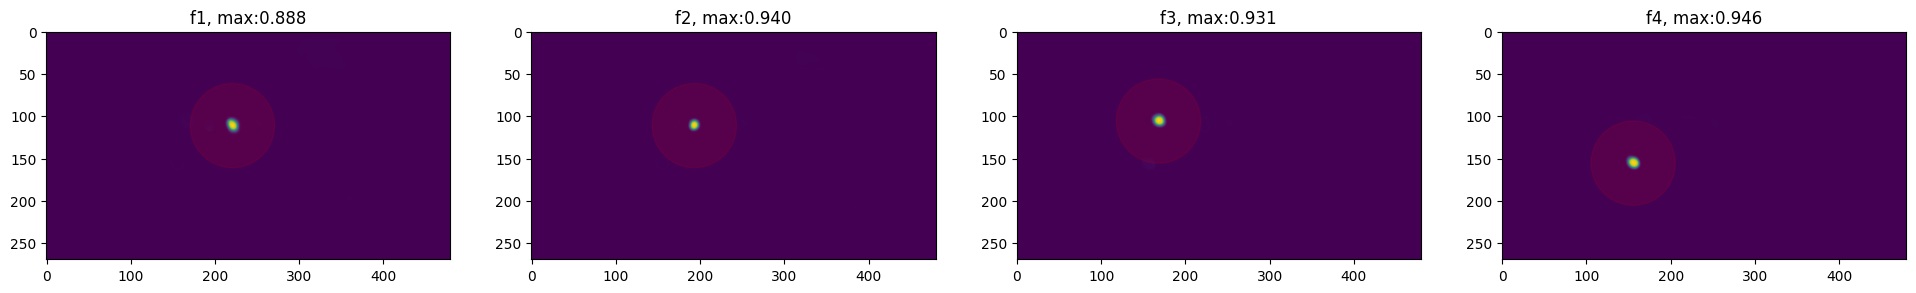

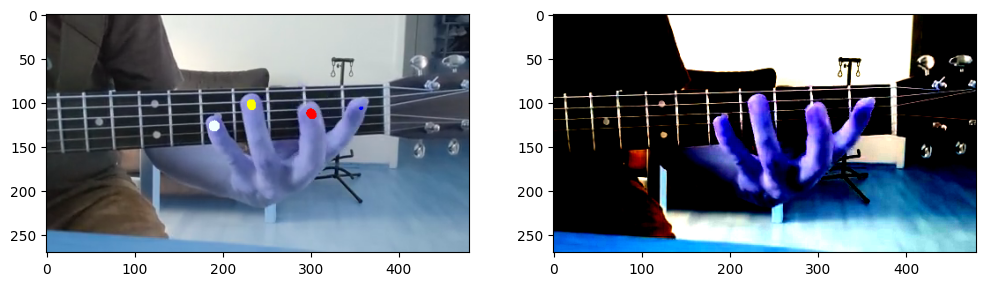

[[[357.11437988 106.40544128   0.64782834]
  [300.67950439 112.72200012   0.96886796]
  [232.69903564 102.44598389   0.9336589 ]
  [190.47306824 126.53892517   0.96353757]]]
frame 940


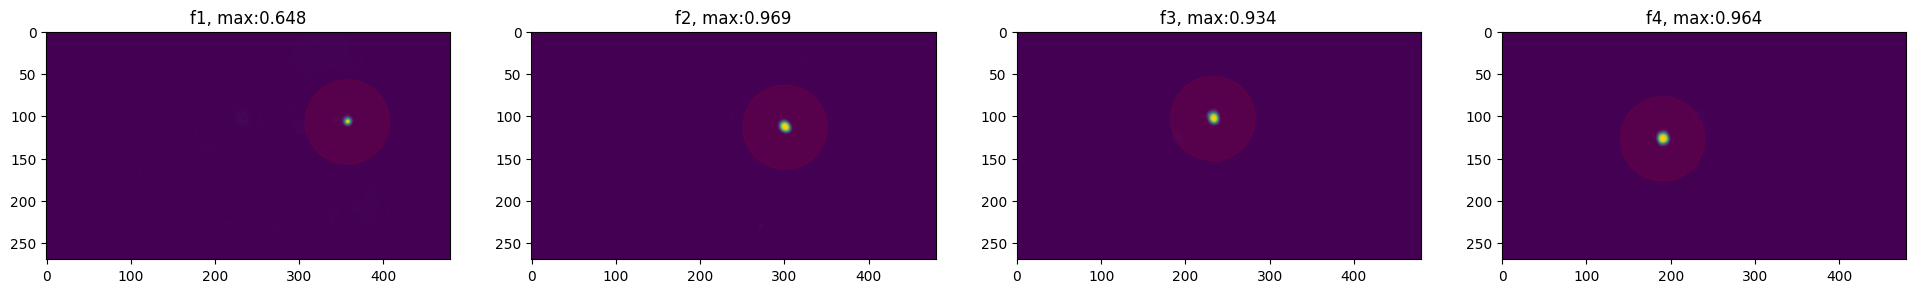

In [ ]:
BGR2RGBTransformation=False

detector = CoordinatesFromSegmentationMask()

cap = cv2.VideoCapture(video_fn)
if (cap.isOpened()== False):
    raise ValueError("Error opening video file")

video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Number of frames in {}: {}".format(video_fn,video_length))

n = 10
sel_frames = np.random.choice(np.arange(video_length),size=n, replace=False)
sel_frames.sort()


for i in sel_frames:
    print("frame",i)
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)

    ret, image = cap.read()

    if ret == False:
        raise ValueError("Error reading video frame")

    input = image.astype(np.float32)
    if BGR2RGBTransformation:
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

    normInput = valTransform(image=input)["image"] # normalize

    # transform to torch tensor, send to gpu, permute the dimensions and unsqueeze to make a batch
    input = torch.tensor(normInput).to(DEVICE).permute(2,0,1).unsqueeze(0).float()

    # model prediction
    output = torch.sigmoid(model(input))
    # batch to image, move to cpu memory, transform to numpy array
    output = output.to("cpu").detach().numpy()

    # draw output onto image
    outputThreshold = (output[0]>0.5).astype("float")

    for j in range(output.shape[1]): # body parts
        idx=(outputThreshold[j]==1.0)
        for c in range(3):
            image[idx,c]=project.object_colors[j][c]

    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].imshow(image)
    ax[1].imshow(normInput)
    plt.show()



    fig, ax = plt.subplots(1,output.shape[1],figsize=((output.shape[1])*6,6))
    for j in range(output.shape[1]):
        ax[j].imshow(output[0,j])
        ax[j].set_title("{}, max:{:0.3f}".format(project.object_list[j],output[0,j].max()))

    coord = detector.detect(output) # coord has shape batchsize,objects,3
    for j in range(coord.shape[1]):
        circle1 = plt.Circle((coord[0,j,0], coord[0,j,1]), 50, color='r',alpha=0.1)
        ax[j].add_patch(circle1)


    print(coord)


cap.release()